Code from https://github.com/moganesyan/tensorflow_model_deployment and A.Geron's book

This notebook enables to run the tensorflow serving model created with python Code/tfs_converter.py and pushed on google cloud AI Platform. 

Unfortunately, the REST call fails because the payload exceeds Google Clouds limit, and the API doesn't provide a GRPC interface (as far as I know). I raised an issue on A.Geron's book github to ask for help. 

In [2]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../glomerulia_service_account_key.json"

In [3]:
import googleapiclient.discovery
project_id="nomadic-freedom-271613"
model_id = "glomerulia_mrcnn"
model_path="projects/{}/models/{}".format(project_id,model_id)
ml_resource = googleapiclient.discovery.build("ml","v1").projects()

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
# import sys
# import time
from PIL import Image

from tfs_transform import ImageTransform
from tfs_preprocess import PreprocessImage
from tfs_postprocess import PostprocessImage

class_names = ['BG', 'glomerulus']
from glomerulus import GlomerulusInferenceConfig
config = GlomerulusInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

Using TensorFlow backend.


In [6]:
transformClass = ImageTransform(config)
preprocessClass = PreprocessImage(config)
postprocessClass = PostprocessImage(config)

# Prepare Image

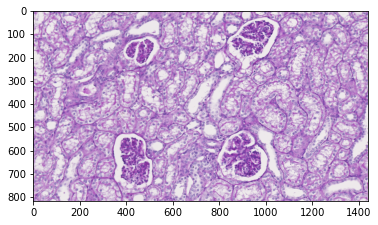

In [7]:
image = np.array(Image.open('../logs/TFS_img_test.tif'))
# If grayscale. Convert to RGB for consistency.
if image.ndim != 3:
    image = skimage.color.gray2rgb(image)
# If has an alpha channel, remove it for consistency
if image.shape[-1] == 4:
    image = image[..., :3]

plt.imshow(image)

In [8]:
molded_image, image_meta, anchors, window = preprocessClass.preprocess_input(image)

# Call Google Api prediction

Rest Json call not working : Request payload size exceeds the limit: 1572864 bytes.">. Turning on gRPC solution

In [13]:
import grpc
import tensorflow as tf
from tensorflow_serving.apis import prediction_service_pb2_grpc
from tensorflow_serving.apis import predict_pb2
import time

In [14]:
channel = grpc.insecure_channel(
    'europe-west4-ml.googleapis.com:8500', 
    options=[('grpc.max_receive_message_length', 4096 * 4096 * 3)]
)

stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)

request = predict_pb2.PredictRequest()
request.model_spec.name = 'glomerulia_mrcnn'
request.model_spec.signature_name = 'serving_default'
np.expand_dims(image, axis=0)

request.inputs['input_image'].CopyFrom(
    tf.make_tensor_proto(np.expand_dims(molded_image, axis=0), shape = np.expand_dims(molded_image, axis=0).shape, dtype = "float32"))
request.inputs['input_image_meta'].CopyFrom(
    tf.make_tensor_proto(np.expand_dims(image_meta, axis=0), shape = np.expand_dims(image_meta, axis=0).shape, dtype = "float32"))
request.inputs['input_anchors'].CopyFrom(
    tf.make_tensor_proto(np.expand_dims(anchors, axis=0), shape = np.expand_dims(anchors, axis=0).shape, dtype = "float32"))

time_start = time.time()
grpc_result = stub.Predict(request)
time_end = time.time()
time_elapsed_sec = time_end - time_start
print('Total elapsed time: {} seconds'.format(time_elapsed_sec))


_Rendezvous: <_Rendezvous of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "failed to connect to all addresses"
	debug_error_string = "{"created":"@1594796595.704564721","description":"Failed to pick subchannel","file":"src/core/ext/filters/client_channel/client_channel.cc","file_line":3818,"referenced_errors":[{"created":"@1594796595.704492271","description":"failed to connect to all addresses","file":"src/core/ext/filters/client_channel/lb_policy/pick_first/pick_first.cc","file_line":395,"grpc_status":14}]}"
>

In [ ]:
input_data_json = {
    "signature_name": "serving_default",
    "instances": [{
                    'input_anchors': anchors.tolist(),
                    'input_image': molded_image.tolist(),
                    'input_image_meta': image_meta.tolist()
                 }]
    }

time_start = time.time()
request = ml_resource.predict(name=model_path,body=input_data_json)
time_end = time.time()
time_elapsed_sec = time_end - time_start
print('Total elapsed time: {} seconds'.format(time_elapsed_sec))

response = request.execute()
if "error" in response:
    raise RuntimeError(response["error"])


In [8]:
def predict(X):
    input_data_json ={"signature_name":"serving_default","instances":X.tolist()}
    request = ml_resource.predict(name=model_path,body=input_data_json)
    response = request.execute()
    if "error" in response:
        raise RuntimeError(response["error"])
    return np.array([pred[output_name] for pred in response["predictions"]])